# Download datasets for mining

In [1]:
import json
import os
import sys
import pickle

import ee
from geojson import Point, Feature, FeatureCollection, dump
import geopandas
from keplergl import KeplerGl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import box, shape, Point, Polygon
from sklearn.manifold import TSNE

sys.path.append('../')
from scripts.get_s2_data_ee import get_history, get_history_polygon, get_pixel_vectors

%load_ext autoreload
%autoreload 2

In [2]:
# Sentinel 2 band descriptions
band_descriptions = {
    'B1': 'Aerosols, 442nm',
    'B2': 'Blue, 492nm',
    'B3': 'Green, 559nm',
    'B4': 'Red, 665nm',
    'B5': 'Red Edge 1, 704nm',
    'B6': 'Red Edge 2, 739nm',
    'B7': 'Red Edge 3, 779nm',
    'B8': 'NIR, 833nm',
    'B8A': 'Red Edge 4, 864nm',
    'B9': 'Water Vapor, 943nm',
    'B11': 'SWIR 1, 1610nm',
    'B12': 'SWIR 2, 2186nm'
}

rect_width = 0.01
scale = 10

In [3]:
def create_img_stack(patch_history):
    mean_stack = []
    dates = list(patch_history.keys())
    for site in patch_history[dates[0]]:
        img_stack = []
        for date in dates:
            spectral_stack = []
            band_shapes = [np.shape(patch_history[date][site][band])[0] for band in band_descriptions]
            if np.array(band_shapes).all() > 0:
                for band in band_descriptions:
                    spectral_stack.append(patch_history[date][site][band])
                img_stack.append(np.rollaxis(np.array(spectral_stack), 0, 3))

        masked_img = []
        for img in img_stack:
            masked_img.append(np.ma.masked_where(img < 0, img))
        
        masked_mean = np.ma.mean(masked_img, axis=0)
        
        num_cloudy_pixels = np.sum(masked_mean.mask)
        cloud_fraction = num_cloudy_pixels / np.size(masked_mean)
        
        print("Cloud Fraction", cloud_fraction)
        if cloud_fraction < 0.2:
            mean_stack.append(masked_mean.data)
    return mean_stack

def normalize(x):
    return (np.array(x)) / (3000)

def create_sampling_grid(min_lon, max_lon, min_lat, max_lat, steps_lon, steps_lat):
    lons = np.linspace(min_lon, max_lon, steps_lon)
    lats = np.linspace(min_lat, max_lat, steps_lat)
    lon, lat = np.meshgrid(lons, lats)
    coords = [[lon, lat] for lon, lat in zip(lon.flatten(), lat.flatten())]
    return coords

def plot_sampling_grid(coords, rect_width=0.025, output=False):
    sampling_df = pd.DataFrame({
        'lon': [coord[0] for coord in coords],
        'lat': [coord[1] for coord in coords],
        })
    
    features = []
    for lon, lat in zip([coord[0] for coord in coords], [coord[1] for coord in coords]):
        rect = box(lon - rect_width / 2, lat - rect_width / 2, lon + rect_width / 2, lat + rect_width / 2)
        features.append(Feature(geometry=rect))
        
    feature_collection = FeatureCollection(features)
    
    map_config = {"version":"v1","config":{"visState":{"filters":[],"layers":[{"id":"ukfrcej","type":"geojson","config":{"dataId":"samples","label":"samples","color":[137,218,193],"columns":{"geojson":"geometry"},"isVisible":True,"visConfig":{"opacity":0.8,"strokeOpacity":0.8,"thickness":1,"strokeColor":[210,0,0]}}}]},"mapStyle":{"styleType":"satellite"}}    }
    
    sampling_map = KeplerGl(height=600, 
                            data={'samples': geopandas.GeoDataFrame.from_features(feature_collection)},
                            config=map_config)
    return sampling_map

def get_image_stack(coords, start_date='2020-05-01', rect_width=0.025, scale=10, num_months=1):
    names = ['sample_' + str(i) for i in range(len(coords))]
    history = get_history(coords, 
                          names,
                          rect_width,
                          start_date=start_date,
                          num_months=num_months,
                          #scale=rect_width * (100 / 0.025)
                          scale=scale
                         )
    img_stack = create_img_stack(history)
    print("Image shape before cropping:", img_stack[0].shape)
    min_dim = np.min([img.shape[:2] for img in img_stack])
    img_stack = [img[:min_dim, :min_dim, :] for img in img_stack]
    
    return history, img_stack

def predict_grid(model, history, img_stack, coords):
    
    preds = model.predict(normalize(img_stack))[:,1]
    
    cloud_free_coords = []
    for site, coords in zip(history[start_date], coords):
        if np.median(history[start_date][site]['B2']) > 0:
            cloud_free_coords.append(coords)

    preds_df = pd.DataFrame({
        'pred': preds,
        'lon': [coord[0] for coord in cloud_free_coords],
        'lat': [coord[1] for coord in cloud_free_coords]}
    )

    return preds_df
    
def write_data(data_frame, file_path, rect_width):
    data_frame.to_csv(file_path + '.csv', index=False)
    
    features = []
    for lon, lat, pred in zip(list(data_frame['lon']), list(data_frame['lat']), list(data_frame['pred'])):
        rect = box(lon - rect_width / 2, lat - rect_width / 2, lon + rect_width / 2, lat + rect_width / 2)
        features.append(Feature(geometry=rect, properties={'pred': pred}))

    feature_collection = FeatureCollection(features)
    with open(file_path + '.geojson', 'w') as f:
       dump(feature_collection, f)
    
    geopandas.GeoDataFrame.from_features(feature_collection).plot(column='pred', 
                                                                  cmap='seismic',
                                                                  figsize=(10, 8),
                                                                  vmin=0,
                                                                  vmax=1)

def stretch_histogram(array, min_val=0.1, max_val=0.75, gamma=1.2):
    clipped = np.clip(array, min_val, max_val)
    stretched = np.clip((clipped - min_val) / (max_val - min_val) ** gamma, 0, 1)
    return stretched

def sample_polygon(polygon_coords, num_samples, rect_width = 0.0075, min_intersection=0.25, plot=False):
    site_polygon = Polygon(polygon_coords)
    min_lon, min_lat, max_lon, max_lat = site_polygon.bounds
    valid_points = []
    
    polygon_area = site_polygon.area
    while len(valid_points) < num_samples:
        rand_point = Point(np.random.uniform(min_lon - rect_width / 4, max_lon + rect_width / 4), 
                           np.random.uniform(min_lat - rect_width / 4, max_lat + rect_width / 4))
        rect = box(rand_point.x - rect_width / 2, rand_point.y - rect_width / 2, rand_point.x + rect_width / 2, rand_point.y + rect_width / 2)
        rect_area = rect.area
        
        if rect_area > polygon_area:
            coverage_area = polygon_area
        else:
            coverage_area = rect.area
            
        if site_polygon.intersection(rect).area / coverage_area > 0.25:
            valid_points.append(rand_point)
        
        if plot:
            if site_polygon.intersection(rect).area / coverage_area > 0.25:
                plt.plot(*rect.exterior.xy, c='C0', alpha=0.5)
                plt.scatter(rand_point.x, rand_point.y, c='C0')
            else:
                plt.plot(*rect.exterior.xy, c='r', alpha=0.25)
                plt.scatter(rand_point.x, rand_point.y, c='r')
                #plt.title(f"Polygon Overlap: {site_polygon.intersection(rect).area / site_polygon.area:.0%}")
    if plot:
        plt.plot(*site_polygon.exterior.xy, c='k', linewidth=2)
        plt.axis('equal')
        plt.show()
    sample_points = [[point.x, point.y] for point in valid_points]
    return sample_points

def sample_geojson(geojson, num_samples, rect_width):
    coords = []
    names = []
    for index, site in enumerate(geojson):
        coords += sample_polygon(site['geometry']['coordinates'][0], num_samples, rect_width)
        names += [f"{index}_{site_num}" for site_num in range(num_samples)]
    print(len(coords), "sampling sites generated")
    return coords, names

## Hand Picked Sites

In [4]:
data_dir = os.path.join('..', 'data')

with open(os.path.join(data_dir, 'MinesPos2018-2020Sentinel.geojson'), 'r') as f:
    positive_sites = json.load(f)['features']
    
with open(os.path.join(data_dir, 'MinesNeg2018-2020Sentinel.geojson'), 'r') as f:
    negative_sites = json.load(f)['features']

with open(os.path.join(data_dir, 'MinesNeg_caleb_selection.geojson'), 'r') as f:
    additional_negative_sites = json.load(f)['features']
    
num_samples = 5

positive_coords, positive_names = sample_geojson(positive_sites, num_samples, rect_width)
negative_coords, negative_names = sample_geojson(negative_sites, 10, rect_width)
selected_negative_coords = [site['geometry']['coordinates'][0:2] for site in additional_negative_sites]
selected_negative_names = ['addtional_negative_' + str(i) for i in range(len(additional_negative_sites))]

negative_coords = negative_coords + selected_negative_coords
negative_names = negative_names + selected_negative_names
print()
print(len(negative_coords), 'negative sites loaded')
print(len(positive_coords), 'positive sites loaded')

205 sampling sites generated
160 sampling sites generated

244 negative sites loaded
205 positive sites loaded


In [5]:
plot_sampling_grid(positive_coords, rect_width)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'ukfrcej', 'type': …

In [6]:
start_date='2019-03-01'
positive_history, positive_img_stack = get_image_stack(positive_coords, 
                                     start_date=start_date, 
                                     rect_width=rect_width, 
                                     scale=scale,
                                     num_months=3
                                    )


  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [17:47<35:35, 1067.71s/it]

 67%|██████▋   | 2/3 [41:43<19:38, 1178.02s/it]

100%|██████████| 3/3 [1:01:37<00:00, 1232.62s/it]


Cloud Fraction 0.41142541087231355
Cloud Fraction 0.0606826801517067
Cloud Fraction 0.08288558786346396
Cloud Fraction 0.2425860969387755
Cloud Fraction 0.17588495575221239
Cloud Fraction 0.05078125
Cloud Fraction 0.10034766118836916
Cloud Fraction 0.1533801020408163
Cloud Fraction 0.19737673830594185
Cloud Fraction 0.17375158027812895
Cloud Fraction 0.03443877551020408
Cloud Fraction 0.02264030612244898
Cloud Fraction 0.022439949431099875
Cloud Fraction 0.08715233881163084
Cloud Fraction 0.05570480404551201
Cloud Fraction 0.021175726927939318
Cloud Fraction 0.0
Cloud Fraction 0.021175726927939318
Cloud Fraction 0.021175726927939318
Cloud Fraction 0.021364795918367346
Cloud Fraction 0.021175726927939318
Cloud Fraction 0.021175726927939318
Cloud Fraction 0.021175726927939318
Cloud Fraction 0.021175726927939318
Cloud Fraction 0.021175726927939318
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Frac

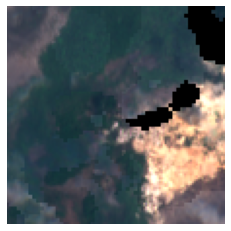

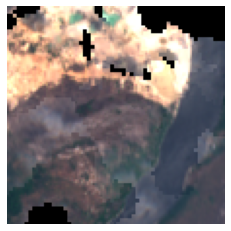

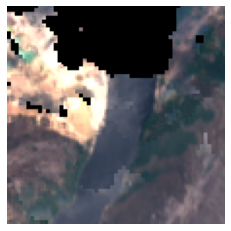

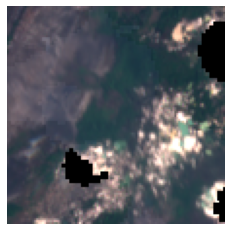

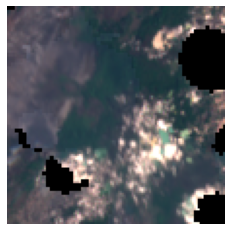

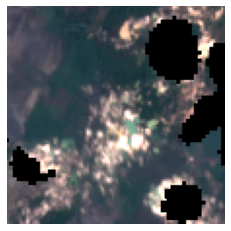

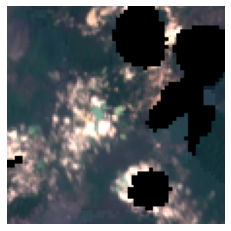

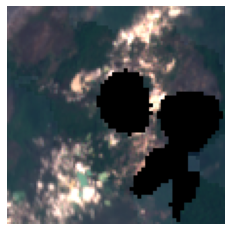

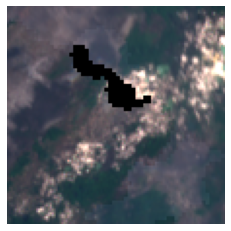

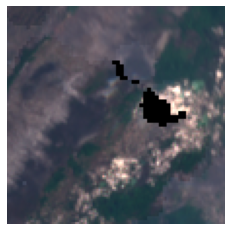

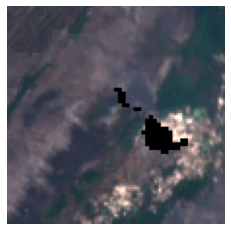

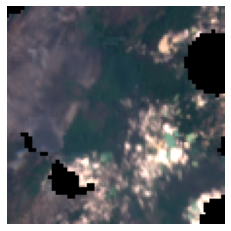

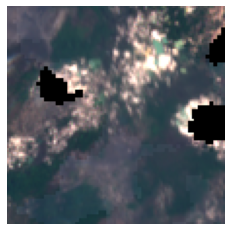

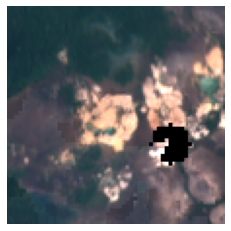

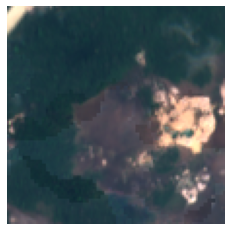

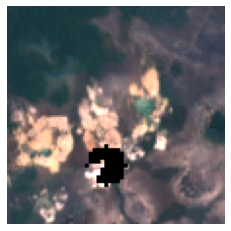

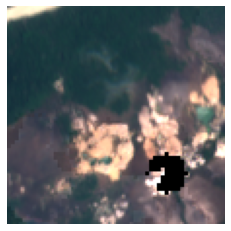

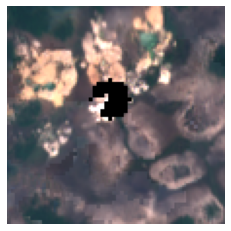

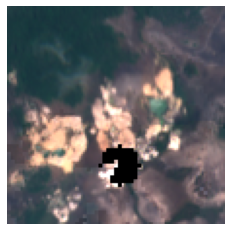

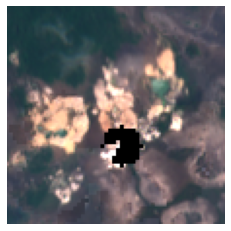

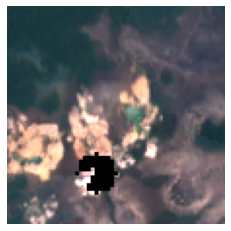

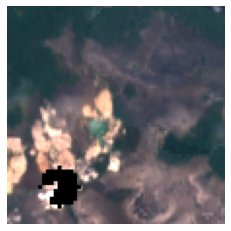

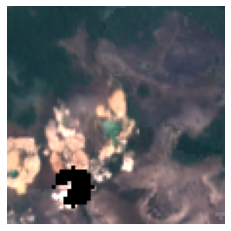

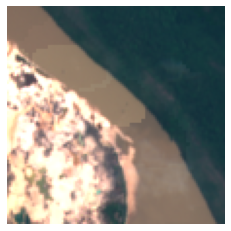

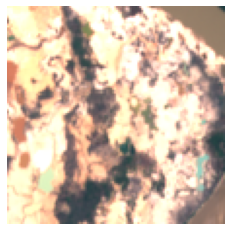

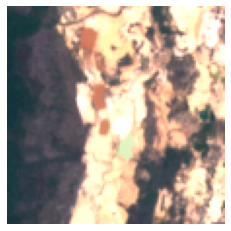

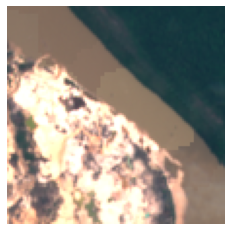

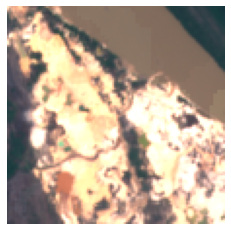

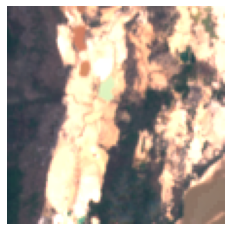

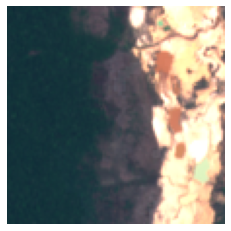

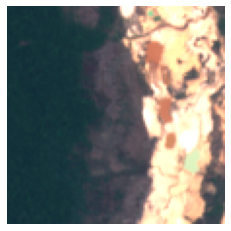

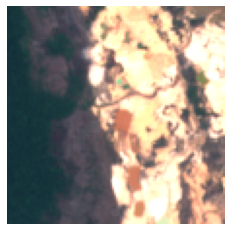

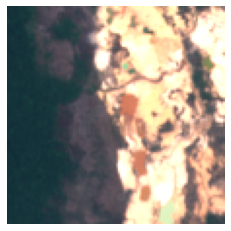

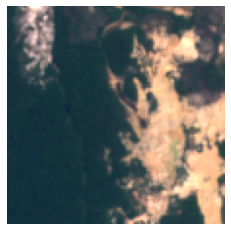

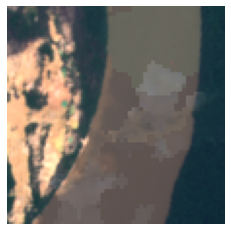

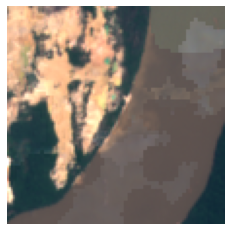

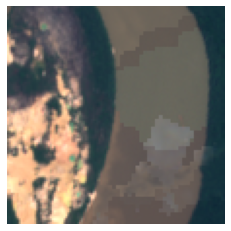

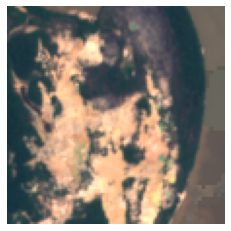

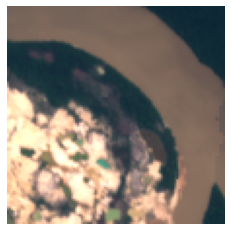

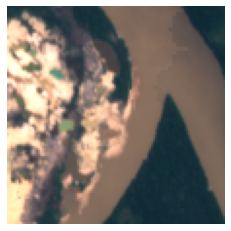

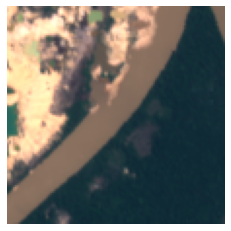

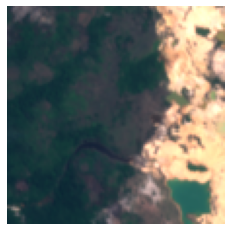

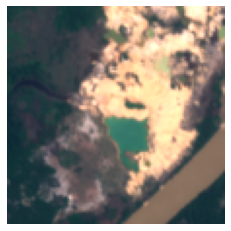

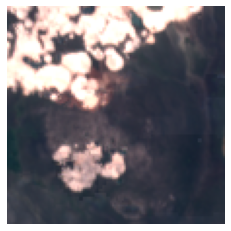

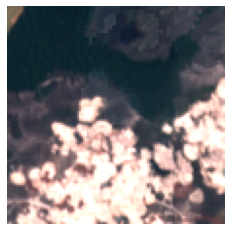

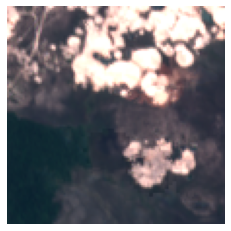

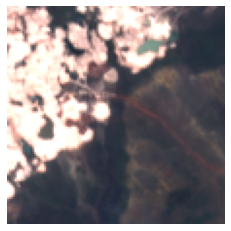

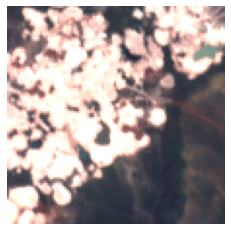

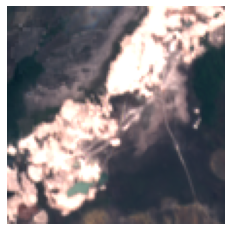

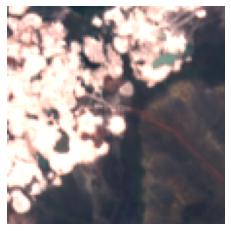

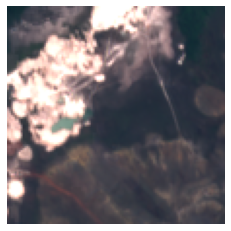

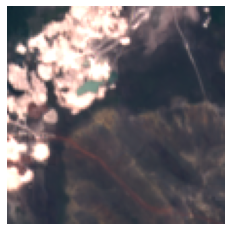

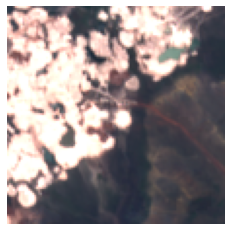

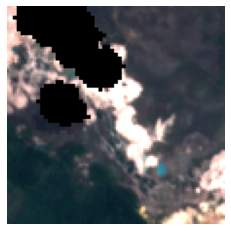

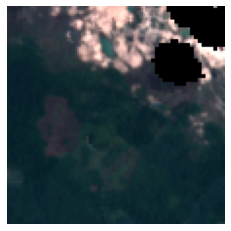

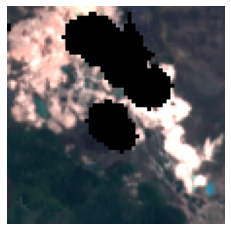

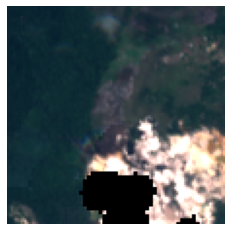

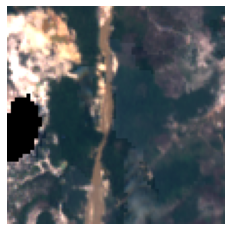

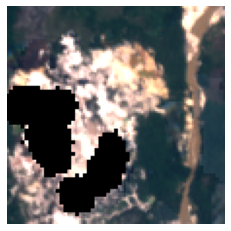

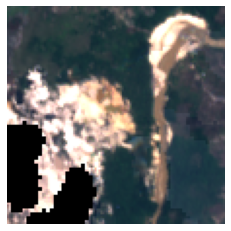

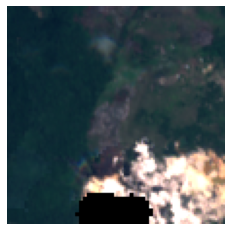

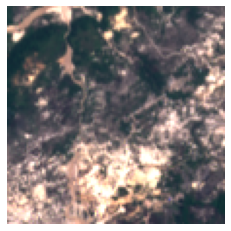

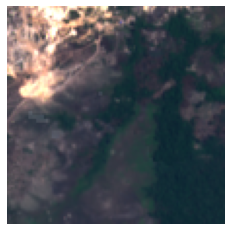

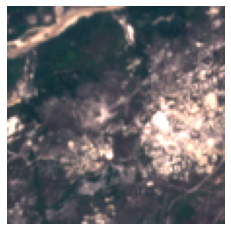

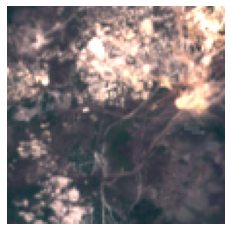

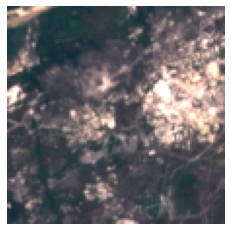

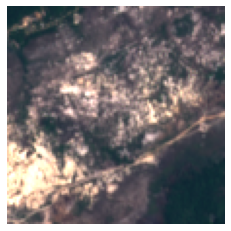

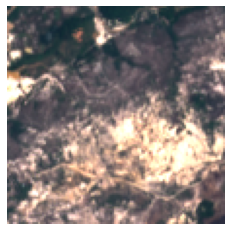

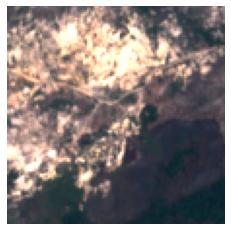

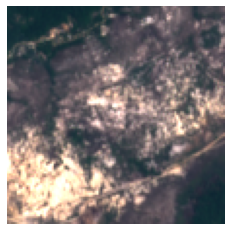

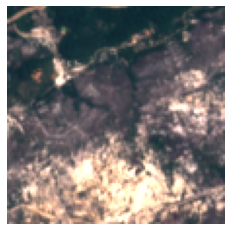

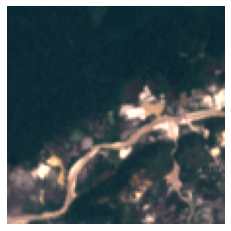

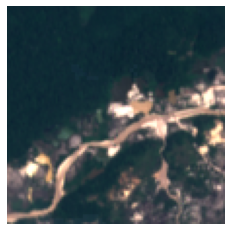

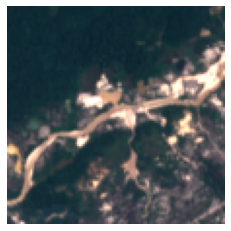

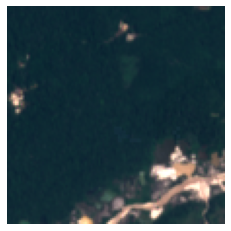

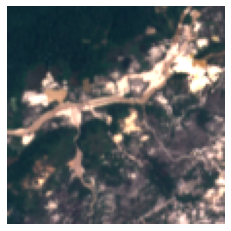

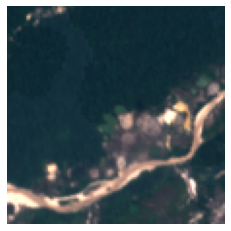

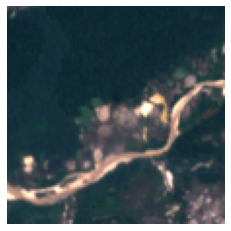

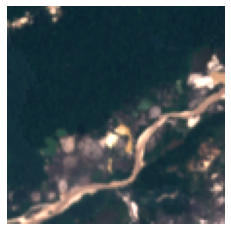

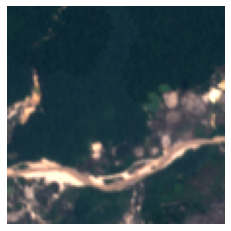

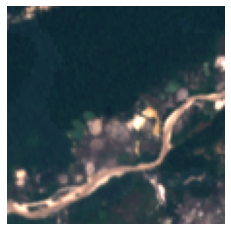

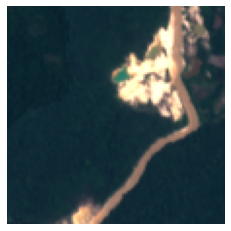

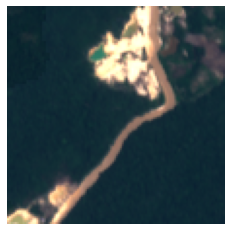

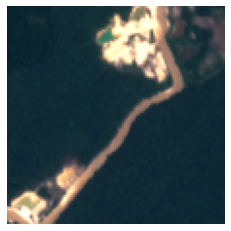

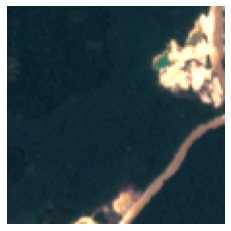

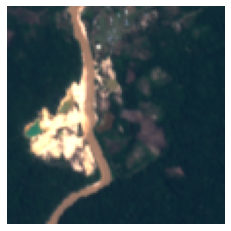

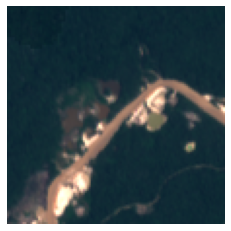

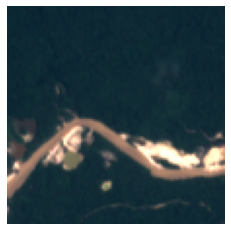

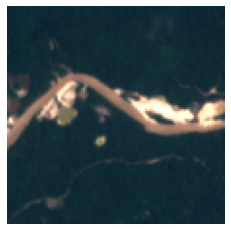

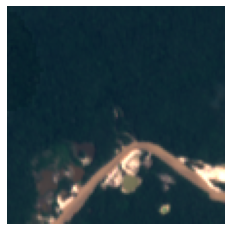

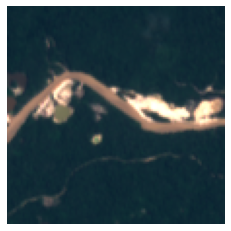

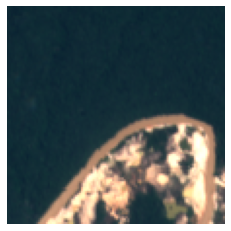

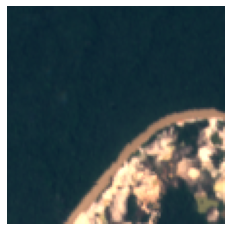

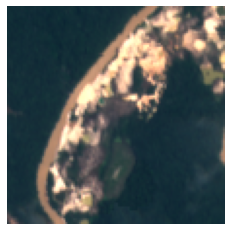

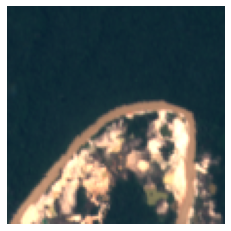

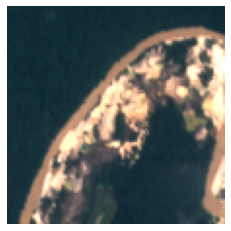

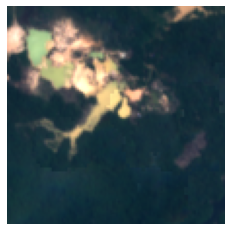

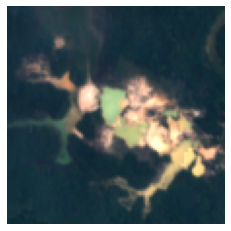

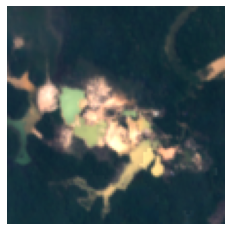

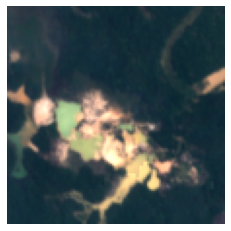

In [7]:
# Preview a selection of images
rgb_img = []
for img in positive_img_stack[:100]:
    rgb = np.stack((img[:,:,3],
                    img[:,:,2],
                    img[:,:,1]), axis=-1)
    rgb = stretch_histogram(normalize(rgb), 0.1, 1)
    rgb_img.append(rgb)
    
for img in rgb_img:
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [ ]:

file_path = f"../data/caroni_positive_84px_5x_polygon_sampling"
with open(file_path + '.pkl', 'wb') as f:
    pickle.dump(positive_img_stack, f)
    print("Wrote file to:", file_path + '.pkl')



In [ ]:

file_path = f"../data/tambopata_mine_{min_lon},{max_lon}_{min_lat},{max_lat}_{rect_width}_{scale}"
with open(file_path + '.pkl', 'wb') as f:
    pickle.dump(img_stack, f)
    print("Wrote file to:", file_path + '.pkl')



In [ ]:
start_date='2019-03-01'
negative_history, negative_img_stack = get_image_stack(negative_coords, 
                                     start_date=start_date, 
                                     rect_width=rect_width, 
                                     scale=scale,
                                     num_months=3
                                    )


## Grid Sample Regions

In [ ]:
rect_width = 0.005

#tambopata whole
min_lon, max_lon = -70.72, -69.8
min_lat, max_lat = -13.2, -12.57

# Caroni whole
#min_lon, max_lon = -63.09674922312161, -62.18700279001181
#min_lat, max_lat = 4.514923184841662, 6.511625537541098

#min_lon, max_lon = -70.64, -70.4
#min_lat, max_lat = -12.96, -13.07

steps_lon = 2
steps_lat = 1

sampling_coords = create_sampling_grid(min_lon, max_lon, min_lat, max_lat, steps_lon, steps_lat)
sampling_map = plot_sampling_grid(sampling_coords, rect_width)
sampling_map

In [ ]:
start_date='2019-05-01'
scale = 10
history, img_stack = get_image_stack(sampling_coords, start_date=start_date, rect_width=rect_width, scale=scale)

file_path = f"../data/tambopata_mine_{min_lon},{max_lon}_{min_lat},{max_lat}_{rect_width}_{scale}"
with open(file_path + '.pkl', 'wb') as f:
    pickle.dump(img_stack, f)
    print("Wrote file to:", file_path + '.pkl')



## Bootstrap Bolivar V1

In [ ]:
import geojson
with open('../outputs/bolivar_10x.geojson', 'r') as f:
    bolivar = geojson.load(f)

In [ ]:
bolivar_preds = np.array([point['properties']['mean'] for point in bolivar[:]])
bolivar_coords = np.array([np.mean(point['geometry']['coordinates'][0], axis=(0)) for point in bolivar[:]])

In [ ]:
threshold = 0.95
bolivar_positive_coords = bolivar_coords[bolivar_preds > threshold]
print(len(bolivar_preds), "total samples")
print(len(bolivar_positive_coords), "samples above prediction threshold of", threshold)

In [ ]:
start_date='2019-05-01'

rect_width = 0.0076
scale = 10
history, img_stack = get_image_stack(bolivar_positive_coords[:500], 
                                     start_date=start_date, 
                                     rect_width=rect_width, 
                                     scale=scale,
                                     num_months=2
                                    )


In [ ]:
img_stack_84 = [img[:84,:84,:] for img in img_stack]
with open('../data/84_px_bolivar_bootstrap_v1.pkl', 'wb') as f:
    pickle.dump(img_stack_84, f)

In [ ]:
rgb_img = []
for img in img_stack:
    rgb = np.stack((img[:,:,3],
                    img[:,:,2],
                    img[:,:,1]), axis=-1)
    rgb = stretch_histogram(normalize(rgb), 0.1, 1)
    rgb_img.append(rgb)

In [ ]:
for img in rgb_img:
    plt.imshow(img)
    plt.axis('off')
    plt.show()

## Bootstrap Bolivar V2

In [ ]:
with open('../outputs/bolivar_10x_bootstrap_v1.geojson', 'r') as f:
    bolivar = geojson.load(f)

In [ ]:
bolivar_preds = np.array([point['properties']['mean'] for point in bolivar[:]])
bolivar_coords = np.array([np.mean(point['geometry']['coordinates'][0], axis=(0)) for point in bolivar[:]])

In [ ]:
threshold = 0.6
bolivar_positive_coords = bolivar_coords[bolivar_preds > threshold]
print(len(bolivar_preds), "total samples")
print(len(bolivar_positive_coords), "samples above prediction threshold of", threshold)

In [ ]:
start_date='2019-05-01'

rect_width = 0.0075
scale = 10
history, img_stack = get_image_stack(bolivar_positive_coords, 
                                     start_date=start_date, 
                                     rect_width=rect_width, 
                                     scale=scale,
                                     num_months=3
                                    )


In [ ]:
with open('../data/84_px_bolivar_bootstrap_v2.pkl', 'wb') as f:
    pickle.dump(img_stack, f)

In [ ]:
rgb_img = []
for img in img_stack:
    rgb = np.stack((img[:,:,3],
                    img[:,:,2],
                    img[:,:,1]), axis=-1)
    rgb = stretch_histogram(normalize(rgb), 0.1, 1)
    rgb_img.append(rgb)

In [ ]:
for img in rgb_img[:100]:
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Test Model

In [ ]:
from tensorflow import keras
inception = keras.models.load_model('../models/84_px_bootstrap_v2_polygon_5x_sample_1_base_sample_100_epochs_02-07-21.h5')
preds = inception.predict(normalize(img_stack))

In [ ]:
num_img = 15
plt.figure(figsize=(16,16), dpi=150)
for index, (img, pred) in enumerate(zip(rgb_img[:num_img ** 2], preds[:num_img ** 2, 1])):
    plt.subplot(num_img, num_img, index + 1)
    plt.imshow(np.clip(img, 0, 1))
    plt.axis('off')
    plt.title(f"{pred:.2f}")
plt.tight_layout()
plt.show()

# Bootstrap V3

In [ ]:
with open('../outputs/bolivar_10x_inception_v1.geojson', 'r') as f:
    bolivar = geojson.load(f)

In [ ]:
bolivar_preds = np.array([point['properties']['mean'] for point in bolivar[:]])
bolivar_coords = np.array([np.mean(point['geometry']['coordinates'][0], axis=(0)) for point in bolivar[:]])

In [ ]:
threshold = 0.9
bolivar_positive_coords = bolivar_coords[bolivar_preds > threshold]
print(len(bolivar_preds), "total samples")
print(len(bolivar_positive_coords), "samples above prediction threshold of", threshold)

In [ ]:
bootstrap_index = np.random.choice(len(bolivar_positive_coords), 1000)

In [ ]:
start_date='2019-03-01'

rect_width = 0.0075
scale = 10
inception_history, inception_img_stack = get_image_stack(bolivar_positive_coords[bootstrap_index], 
                                     start_date=start_date, 
                                     rect_width=rect_width, 
                                     scale=scale,
                                     num_months=3
                                    )


In [ ]:
inception_rgb_img = []
for img in inception_img_stack:
    rgb = np.stack((img[:,:,3],
                    img[:,:,2],
                    img[:,:,1]), axis=-1)
    rgb = stretch_histogram(normalize(rgb), 0.1, 1)
    inception_rgb_img.append(rgb)

In [ ]:
len(inception_rgb_img)

In [ ]:
for img in inception_rgb_img[:100]:
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [ ]:
with open('../data/84_px_bolivar_inception_bootstrap_v3.pkl', 'wb') as f:
    pickle.dump(inception_img_stack, f)

# Dense River 84px patch sampling

In [ ]:
dense_river_samples = pd.read_csv(os.path.join(data_dir, 'dense_river_0.01.csv'))
dense_river_coords = [[lon, lat] for lon, lat in zip(dense_river_samples['lon'], dense_river_samples['lat'])]
start_date='2019-03-01'

rect_width = 0.0075
scale = 10
river_history, river_img_stack = get_image_stack(dense_river_coords, 
                                     start_date=start_date, 
                                     rect_width=rect_width, 
                                     scale=scale,
                                     num_months=2
                                    )


In [ ]:
river_rgb_img = []
for img in river_img_stack:
    rgb = np.stack((img[:,:,3],
                    img[:,:,2],
                    img[:,:,1]), axis=-1)
    rgb = stretch_histogram(normalize(rgb), 0.1, 1)
    river_rgb_img.append(rgb)

In [ ]:
for img in river_rgb_img[:100]:
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [ ]:
model = keras.models.load_model('../models/84_px_inception_v4_02-08-21.h5')
preds = model.predict(normalize(river_img_stack))

In [ ]:
pd.DataFrame({
    'preds': preds[:,1], 
    'lon': [coord[0] for coord in dense_river_coords],
    'lat': [coord[1] for coord in dense_river_coords]}).to_csv('../outputs/dense_river_84px_preds.csv')